<hr style="border:2px solid gray"> </hr>
<img src="https://mma.prnewswire.com/media/1095203/East_Tennessee_State_University_Logo.jpg?p=facebook" width=200 height=200 />

<div class="alert alert-block alert-info">
    <h1 style="text-align: center">CSCI 5037 - NLP & Text Analysis</h1>
</div>

# <center>Text Classification</center>

**<center>Dr. Ahmad Al-Doulat </center>**
<center>Department of Computing </center>
<center>East Tennessee State University</center>

<hr style="border:2px solid lightblue"> </hr>

**Text classification** is a machine learning technique that assigns a set of predefined categories to open-ended text. Text classifiers can be used to organize, structure, and categorize pretty much any kind of text – from documents, medical studies and files, and all over the web.

For example, new articles can be organized by topics; support tickets can be organized by urgency; chat conversations can be organized by language; brand mentions can be organized by sentiment; and so on.

Text classification is one of the fundamental tasks in natural language processing with broad applications such as sentiment analysis, topic labeling, spam detection, and intent detection.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gzip
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
np.random.seed(123456)

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm

import keras
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [2]:
plt.style.use('seaborn')

# IMDB Dataset

In [3]:
top_words = 10_000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

Each word is associated with a unique ID. We can easily obtain the dictionary mapping words to IDs

In [4]:
word_dict = imdb.get_word_index()

So we can check what the id of each word is

In [5]:
word_dict['casting']

970

In [6]:
word_dict['director']

164

We also invert the index so that we can recover the original text. A few special tokens are reserved at the beginning of the id range

In [7]:
word_list = ["<PAD>", "<START>", "<UNK>", "UNUSED"]
word_list.extend([k for k, v in sorted(word_dict.items(), key = lambda x:x[1])])
word_list = np.array(word_list)

In [8]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [9]:
" ".join(word_list[X_train[0]])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

Each review has associated with it a value of 0 or 1.

In [10]:
set(y_train)

{0, 1}

So the corresponding rating for review is

In [11]:
y_train[0]

1

1 means positive, while 0 means negative

In [12]:
" ".join(word_list[X_train[4]])

"<START> worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the <UNK> and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

In [13]:
y_train[4]

0

Our dataset is split into two equal parts, the training and the testing dataset

In [14]:
print('Shape of training data:', X_train.shape)
print('Shape of test data:', X_test.shape)

Shape of training data: (25000,)
Shape of test data: (25000,)


# Feed Forward Model

We'll start by training a simple FF model without any fancyness. The first step is to pad each instance so that they all have the same size. Here we'll use the first 450 words. If the review is longer, we trucate it, while if its shorter we pad it

In [15]:
max_words = 500
X_train = keras.utils.pad_sequences(X_train, maxlen=max_words)
X_test = keras.utils.pad_sequences(X_test, maxlen=max_words)

In [16]:
" ".join(word_list[X_train[0]])

"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

## Model Structure

Our model will have an embedding layer to turn our numerical ids into vectors, a hidden dense layer of 32 neurons and ReLu activation followed by an output layer with just one neuron and a sigmoid activation

In [17]:
model = Sequential()
model.add(keras.layers.Embedding(top_words, 50, input_length=max_words))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In summary:

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Next we compile our model using a binary cross entropy loss function and the Adam optimizer

In [19]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

The final step is to fit the model using the training data. We also supply the test data for validation purposes

In [20]:
history = model.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=10,
                   batch_size=128,
                   verbose=1)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.6328 - loss: 0.6010 - val_accuracy: 0.8713 - val_loss: 0.2990
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9352 - loss: 0.1792 - val_accuracy: 0.8716 - val_loss: 0.3040
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9888 - loss: 0.0519 - val_accuracy: 0.8642 - val_loss: 0.3623
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9989 - loss: 0.0117 - val_accuracy: 0.8631 - val_loss: 0.4102
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9998 - loss: 0.0034 - val_accuracy: 0.8637 - val_loss: 0.4409
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8624 - val_loss: 0.4743
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8645 - val_loss: 0.4790
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 1.0000 - loss: 6.3187e-0

Small utility function to display the results

In [21]:
def plot_history(history):
    fig, ax_lst = plt.subplots(1, 2, sharex=True, sharey=True)

    epochs = np.array(history.epoch) + 1

    ax_lst[0].plot(epochs, history.history['loss'], label='Training')
    ax_lst[0].plot(epochs, history.history['val_loss'], label='Testing')
    ax_lst[0].set_ylabel('Loss')
    ax_lst[0].set_xlabel('Epoch')
    ax_lst[0].set_xticks(epochs)

    ax_lst[1].plot(epochs, history.history['accuracy'], label='Training')
    ax_lst[1].plot(epochs, history.history['val_accuracy'], label='Testing')
    ax_lst[1].set_ylabel('Accuracy')
    ax_lst[1].set_xlabel('Epoch')
    ax_lst[1].set_xticks(epochs)

    fig.tight_layout()

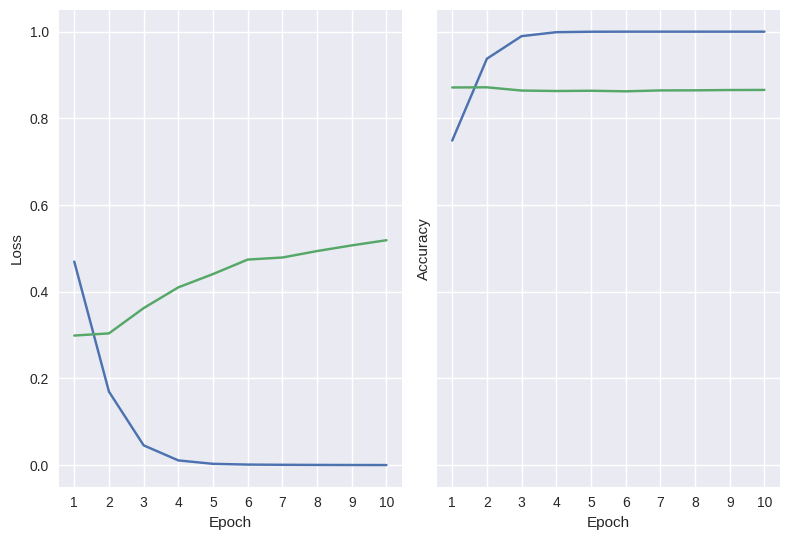

In [22]:
plot_history(history)

Looks like we are overfitting the data after just a few epochs

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Fit the model with EarlyStopping callback
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping]  # Include EarlyStopping here
)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 1.0000 - loss: 2.6239e-04 - val_accuracy: 0.8651 - val_loss: 0.5291
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 1.0000 - loss: 2.1045e-04 - val_accuracy: 0.8658 - val_loss: 0.5393
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 1.0000 - loss: 1.6584e-04 - val_accuracy: 0.8651 - val_loss: 0.5484
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 1.0000 - loss: 1.3974e-04 - val_accuracy: 0.8664 - val_loss: 0.5577


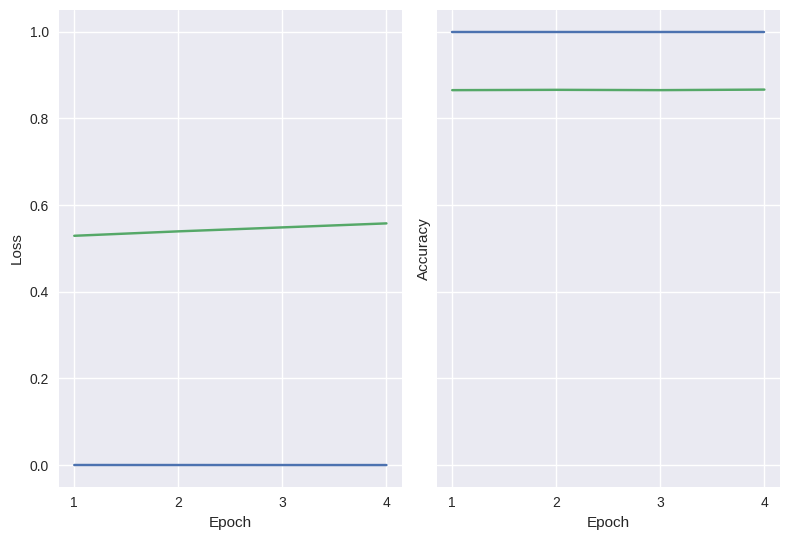

In [24]:
plot_history(history)

# Convolutional Model

Now we add a convolution layer between the embedding layer and the dense layer

In [25]:
model = Sequential()
model.add(keras.layers.Embedding(top_words, 50, input_length=max_words))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Compile and fit the model

In [26]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [27]:
history = model.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=10,
                   batch_size=128,
                   verbose=1)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 149ms/step - accuracy: 0.6270 - loss: 0.5951 - val_accuracy: 0.8888 - val_loss: 0.2702
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9307 - loss: 0.1934 - val_accuracy: 0.8874 - val_loss: 0.2722
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 152ms/step - accuracy: 0.9616 - loss: 0.1152 - val_accuracy: 0.8788 - val_loss: 0.3063
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 151ms/step - accuracy: 0.9803 - loss: 0.0680 - val_accuracy: 0.8765 - val_loss: 0.3745
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - accuracy: 0.9915 - loss: 0.0363 - val_accuracy: 0.8717 - val_loss: 0.4745
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.9975 - loss: 0.0152 - val_accuracy: 0.8715 - val_loss: 0.5575
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9996 - loss: 0.0047 - val_accuracy: 0.8696 - val_loss: 0.6447
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 32s 163ms/step - accuracy: 0.9999 - loss: 0

This model takes significantly longer to train, but produces much better results

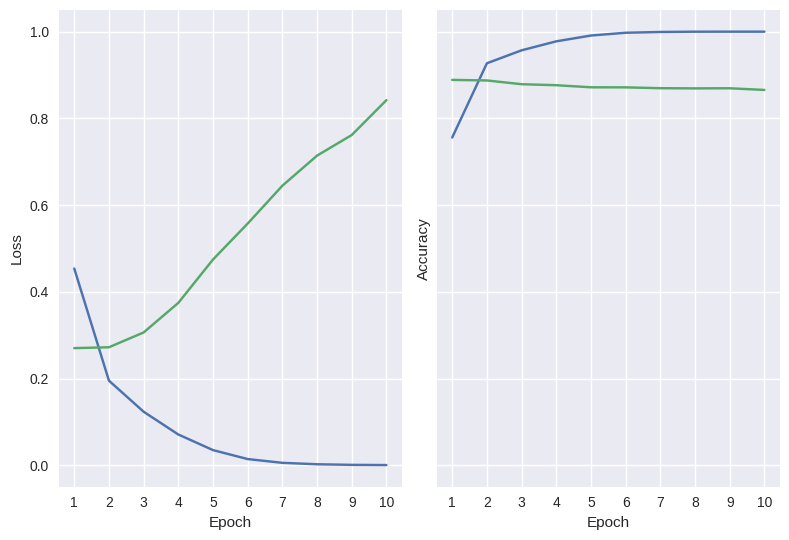

In [28]:
plot_history(history)